<table>
  <tr>
    <td><img src="https://github.com/rvss-australia/RVSS/blob/main/Pics/RVSS-logo-col.med.jpg?raw=1" width="400"></td>
    <td><div align="left"><font size="30">Camera Calibration using 3D calibration object</font></div></td>
  </tr>
</table>

(c) Peter Corke 2024

To make this run nicely in CoLab we have to install a bunch of packages. This will be slow and at the end you will need to restart the kernel. Push the RESTART KERNEL button that appears or from the menu above Runtime/RestartRuntime

In [1]:
try:
    import google.colab
    print('Running on CoLab')
    !pip install machinevision-toolbox-python
    COLAB = True
except:
    COLAB = False

Now, we can import some of the packages we need throughout, Matplotlib and NumPy, and configure the CoLab environment a bit.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

from machinevisiontoolbox import Image, CentralCamera
import matplotlib.pyplot as plt
import numpy as np
from spatialmath import SE3, SO3
from spatialmath import base

np.set_printoptions(linewidth=120, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})


# Create a MVTB central camera model
def CreateUnknownCamera(x=1, y=-1, z=0.01, roll=-92, pitch=2, yaw=50, image_size=(1280,1024), f=0.015):
    """Create a Machine Vision Toolbox central camera model given 6 DoF pose, image size and f.
        
        Args In: 
            x - position of camera in x-axis world frame (in metres)
            y - position of camera in y-axis world frame (in metres)
            z - position of camera in z-axis world frame (in metres)
            roll - rotation of the camera about the x-axis world frame (in degrees)
            pitch - rotation of the camera about the y-axis world frame (in degrees)
            yaw - rotation of the camera about the z-axis world frame (in degrees)
            image_size - two element tuple specifying the width and height of the image (in pixels)
            f - focal length
            
       Returns:
           a camera model
        
    """
    
    # Establish a camera position with respect to the world frame
    # position
    t_cam = np.r_[x, y, z] 
    
    # orientation
    R = SO3.Rz(yaw, 'deg') * SO3.Ry(pitch, 'deg') * SO3.Rx(roll, 'deg')
    
    # Create full transformation matrix
    T = SE3(t_cam) * SE3(R)
    
    # print(T)
    
    # Create camera model
    return CentralCamera(imagesize=image_size, f=f, rho=10e-6, pose=T)

In this notebook we are going to investigate how we can calibrate a camera to determine the camera's intrinsic and extrinsic parameters. When we calibrate a camera we take an image of a calibration rig and associate certain points/features within that image to real-world coordinates. We can then determine the camera parameters using an optimisation method, for example least-squares.  

Before we dive into real-world data we are going to create a situation where we know the camera parameters, the real-world points and where these points would lie if an image was taken from a specific pose.

# Calibration Rig

We will be using data for the following calibration rig which consists of 12 dots forming three 6cm squares on three planes. We will store the real-world 3D coordinates that reflect the markers on the calibration target in the matrix `P_calib`. We will be using `P_calib` throughout this coding session.

![calibration](https://github.com/Tobias-Fischer/RVSS2022/blob/main/Robotic_Vision/common/calibration-fixture.png?raw=1)

In [3]:
cm = 0.01 # centimetre to metre conversion factor

P_calib = np.array([
    [ 0,  -12.2, 12.2],
    [ 0,   -6.2, 12.2],
    [ 0,  -12.2,  6.2],
    [ 0,   -6.2,  6.2],
    [ 6.2,  0,   12.2],
    [12.2,  0,   12.2],
    [ 6.2,  0,    6.2],
    [12.2,  0,    6.2]
]).T * cm

# Calibrating A Simulated Camera

## Simulate a Camera

First, we will simulate a "black box" camera. While we know the pose and charateristics of this camera (you can check them out in the `CreateSimulatedCamera` function, but we will assume we do not and see if we can find the camera extrinsic and intrinsic parameters ourself using simulated calibration data.


In [4]:
unknown_camera = CreateUnknownCamera()
unknown_camera

           Name: perspective [CentralCamera]
     pixel size: 1e-05 x 1e-05
     image size: 1280 x 1024
           pose: t = 1, -1, 0.01; rpy/yxz = 93.7°, -39.9°, -92.6°
   principal pt: [     640      512]
   focal length: [   0.015    0.015]

The object `unknown_camera` is a model of the camera and was computed using the `CreateCameraModel` function above (in the second code cell of this notebook). For now we will pretend we don't know it's characteristics, and that its pose is unknown with respect to the calibration target.

However **we do know** the world coordinates of the markers.

We can create an "artificial" image of the 3D points by projecting these points onto the 2D image plane within our simulated camera, by using the code below. *We can only do this because we know camera characteristics, as well as the pose of the camera and the locations of the 3D points with respect to the world frame.*

In [5]:
p = unknown_camera.project_point(P_calib)
p

array([[   669.3,      719,    671.6,    721.1,    815.9,    866.2,      818,    868.3],
       [   331.7,    333.6,    399.7,    399.6,    329.5,    323.4,    395.9,    392.1]])

Projecting the 3D coordinates of the calibration target markers onto the  into 2D image plane coordinates using the camera object's `project` method

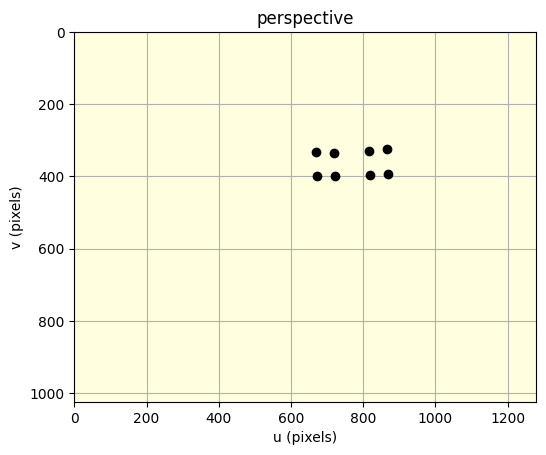

array([[   669.3,      719,    671.6,    721.1,    815.9,    866.2,      818,    868.3],
       [   331.7,    333.6,    399.7,    399.6,    329.5,    323.4,    395.9,    392.1]])

In [6]:
unknown_camera.plot_point(P_calib)


Of course, with real camera calibration these 2D coordinates must be obtained by taking an image and finding the coordinates of the points in the captured image. We will be using a real-image later.

## Compute the Camera Matrix 

We can noe compute the camera calibration from the calibration data, the real-world coordinates `P_calib` and the 2D image coordinates `p`.

 * `P_calib`, is an array of 3D points which is a $3 \times N$ matrix, one point per column (which would be found by measuring the points in the real-world)
 * `p`, is an array of 2D points which is a $2 \times N$ matrix, one point per column (which would be found in the captured image)
    
Importantly, the points correspond, that is the $i^{th}$ column of `p` is the projection of the 3D point in the $i^{th}$ column of `P_calib`.

The camera matrix $\mathbf{C}$ can be computed by

In [7]:
C, residual = CentralCamera.points2C(P_calib, p)
residual

1.5802470443304628e-11

the small residual is an encouraging sign, it indicates that the data is a good fit to the projection model of a perspective camera. *This is to expected in this case as we found `p` by projecting the 3D points using our artificial camera model*

The value of the camera matrix is

In [8]:
C

array([[     336,     1107,   -53.03,    771.6],
       [    -274,    180.9,    -1077,    465.7],
       [ -0.5442,   0.4555, -0.02477,        1]])

The intrinsic and extrinsic parameters of the camera are jumbled up in these 12 numbers, but we can unjumble them

In [9]:
camera = CentralCamera.decomposeC(C)
camera


           Name: invC [CentralCamera]
     pixel size: 1.0 x 1.0000000000001632
           pose: t = 1, -1, 0.01; rpy/yxz = 93.7°, -39.9°, -92.6°
   principal pt: [     640      512]
   focal length: [    1500     1500]

This is a classmethod of the `CentralCamera` class and returns a `CentralCamera` instance with the intrinsic and extrinsic parameters consistent with the camera matrix `C`.

**Note:** When computing the camera matrix the focal length and the pixel dimensions are multiplied together, so it's not possible to determine them individually.  This function assumes that the pixel dimension is 1 (this would be metres, so massive pixels!) and the focal length has units of pixels rather than metres (hence the large values).

The intrinsic parameters are

In [10]:
camera.K

array([[    1500,        0,      640],
       [       0,     1500,      512],
       [       0,        0,        1]])

Notice that the values in the top left are half image width and height we specified and that focal length (1500) is a factor of the length we provided into the `CreateSimulatedCamera` function. Naturally, because we are passing in exact data then getting back exact values is to be expected.

The extrinsic parameters, the pose, of the camera with respect to the world calibration frame, is

In [11]:
Tcam = camera.pose
print(Tcam)

   0.6424    0.004315 -0.7664    1         
   0.7656   -0.04915   0.6415   -1         
  -0.0349   -0.9988   -0.03488   0.01      
   0         0         0         1         



This indicates the position of the camera is (1, -1) on the ground plane, and slightly above the ground (z=0.01).

The orientation of the camera can be extracted from its SE(3) pose 

In [12]:
rpy = Tcam.rpy(order='zyx', unit='deg')
rpy

array([     -92,        2,       50])

which indicates the orientation of the camera can be described by three consecutive rotations, in the order:

1. a rotation of 50° about the z-axis, which points the camera toward the calibration target
2. a rotation of 2° about the y-axis, which indicates some imperfection in the calibration process, a small rotation (pan) about the vertical axis
3. a rotation of -92° about the x-axis, which makes the camera's z-axis (it's line of sight) approximately parallel to the ground plane, again some imperfection so the camera is actually pointing slightly toward the floor.

**The angles are provided to the function in the order roll, pitch, yaw, but they are are applied to the coordinate frame in the order yaw, pitch, roll.**

That is all that is required to determine the camera charateristics. You simply need two sets of points, one from the real-world and one with the corresponding 2D image coordinates, you need at least 6 corresponding points.

You can choose to peek at the "unknown" camera model in `CreateCameraModel.py` and see that the parameters we have estimated simply from 3D and 2D data points matches the parameters of that camera.


## Mapping Ground Plane Coordinates to the Image Plane

The extrinsic parameters indicate where the camera is with respect to the world frame. For our project we want to know the coordinate of a point on the ground relative to the camera which is mounted on a robot moving across a ground plane. We define a pair of coordinates frames as per this diagram

![frames](https://github.com/Tobias-Fischer/RVSS2022/blob/main/Robotic_Vision/images/coordinate-frames.png?raw=1)

The robot frame {R} is attached to the robot with its x-axis to the right, y-axis forward and z-axis upward. This frame sits on the ground plane, as does the world-coordinate frame we used for calibration (shown in the first figure in this notebook).

The camera frame {C} is attached to the camera and has its x-axis to the right, y-axis downwards and z-axis (line of sight) forward.

The relative pose of frame {C} with respect to frame {R} has two components: a translation $t$ and a rotation $\mathbf{R}$.

The translation is purely in the z-direction, and our calibration process gave us the height of the camera above the ground.  Therefore

In [13]:
t = [0, 0, Tcam.t[2]] # Tcam.t[2] is the position of the camera in the world frame z-axis
t

[0, 0, 0.009999999999997452]

To rotate the z-axis from upwards (frame {R}) to forwards (in frame {C}) is a rotation of -90° about the x-axis.  However our camera calibration indicated the angle was slightly different to that, -92° in fact.  There is also a slight rotation about the y-axis of 2°.  We will assume that there is no error in the rotation about the z-axis (there is actually no way to identity if there was).  

Therefore the orientation of the camera frame {C} relative to the robot frame {R} is

In [14]:
R = SO3.Ry(rpy[1], 'deg') * SO3.Rx(rpy[0], 'deg')
R

   0.9994   -0.03488  -0.001218  
   0        -0.0349    0.9994    
  -0.0349   -0.9988   -0.03488   


Now we can combine the translation and rotation into a single homogeneous transformation

In [15]:
T = SE3(t) * SE3.Rt(R)
print(T)

   0.9994   -0.03488  -0.001218  0         
   0        -0.0349    0.9994    0         
  -0.0349   -0.9988   -0.03488   0.01      
   0         0         0         1         



Both `SO3` and `SE3` are classes defined in [Spatial Maths for Python](https://github.com/petercorke/spatialmath-python) and encapsulate the functionality that was introduced in lecture B1 on Monday.

The camera model that was estimated from the camera matrix has valid intrinsic parameters but we want to change the  extrinsics.  Now we care about where the camera is with respect to {R} not where it is with respect to the calibration frame, so we will override the extrinsics

In [16]:
camera.pose = T
print(camera)

           Name: invC [CentralCamera]
     pixel size: 1.0 x 1.0000000000001632
           pose: t = 0, 0, 0.01; rpy/yxz = 180°, -88°, -178°
   principal pt: [     640      512]
   focal length: [    1500     1500]



We can use this model to investigate how world points are mapped to the image plane.

Points on the ground 0.5m and 0.6m in front of the camera appear at the following locations on the image plane

In [17]:
P = np.array([[0, 0.4, 0], [0, 0.6, 0]]).T
camera.project_point(P)

array([[   641.3,    640.9],
       [   497.1,    484.6]])

The second column corresponds to the point that is further from the camera and it is ~13 pixels higher in the image.

We note that the u-coordinate of both points is close to the u-coordinate of the principal point (640), the centre of the image, which indicates that the world point is close to the optical axis (as the x-coordinate of 0 would indicate).  Remember that the camera is slightly skewed with respect to the robot frame.

The camera matrix, that encodes the intrinsic and extrinsic parameters of the camera, is now

In [18]:
camera.C()

array([[    1498,    639.6,   -74.67,   0.7467],
       [  -52.94,    459.3,    -1516,    15.16],
       [-0.001218,   0.9994, -0.03488, 0.0003488]])

## Mapping image-plane coordinates to the ground plane

In the previous section we intuitively worked through how we can map ground points into the image plane. Now we will see how can we do the opposite, but we will take a more principled approach. 

Points on the ground plane have a z-coordinate of zero.  The camera projection equation, in matrix form, is
$$
\tilde{p} = \begin{pmatrix} c_1 & c_2 & c_3  & c_4 \end{pmatrix} \begin{pmatrix} X \\ Y \\ Z \\ 1 \end{pmatrix}
$$
where $c_i$ is the $i^{th}$ column of the camera matrix.  Since $Z=0$ we can rewrite as 

\begin{align}
\tilde{p} & = \begin{pmatrix} c_1 & c_2 & c_4 \end{pmatrix} \begin{pmatrix} X \\ Y \\ 1 \end{pmatrix} \\
          & = \mathbf{H} \begin{pmatrix} X \\ Y \\ 1 \end{pmatrix}
\end{align}
where $(X, Y)$ is a point on the ground plane with respect to the camera frame which has the Y-axis forward and the X-axis to the right.

In this case $\mathbf{H}$ is

In [19]:
H = camera.C()[:,[0,1,3]]
H

array([[    1498,    639.6,   0.7467],
       [  -52.94,    459.3,    15.16],
       [-0.001218,   0.9994, 0.0003488]])

which is both square and non-singular

In [20]:
np.linalg.det(H)

-22499.999999959262

which means we have an invertible mapping between 2D points in the image plane and 2D points on the ground plane, both expressed in homogenous form.  Such a transformation is called an *homography*.

**Note that in general we cannot map a 2D point to a 3D point, since a 2D image plane coordinate corresponds to a ray in space -- an infinite number of points.  However the constraint that the point lies on the ground plane makes a unique solution possible, it is the point where that ray intersects the ground plane.**

Consider a point in the image plane at $(300, 600)$

In [21]:
p = (300, 600)  # make homogeneous
P_groundplane = base.h2e(np.linalg.inv(H) @ base.e2h(p))
print(P)

[[       0        0]
 [     0.4      0.6]
 [       0        0]]


and this is corresponding point coordinate on the ground plane. x=-0.027 indicates it is to the left of the robot, and y=0.117 indicates it is in-front of the robot.

We can cross check this by reprojecting that world point back to the image plane using our camera model

In [22]:
P = np.vstack((P_groundplane, 0))  # point is on the ground, add Z=0
print(P)
camera.project_point(P)

[[-0.02686]
 [  0.1166]
 [       0]]


array([[     300],
       [     600]])

and we obtain, as we should do, the image plane coordinate that we started with.

## Summary

1. Using corresponding 3D and 2D data we can estimate a camera matrix.
2. We can untangle the elements of that matrix into intrinsic and extrinsic parameters.
3. We use an estimated camera model to form an homography which maps between image plane and ground plane.

# Using data from real calibration image

Now you get to apply what you've learned above using a real image of a calibration target. The next section of code will display an image and a text widget showing an $8 \times 2$ array. 

You will need to:

1. display the image of the calibration target
2. use `points = plt.ginput(n=8)` and click the centre of each point as accurately as you can, in the order given by the diagram at the top of this notebook.
2. If you make a mistake, do a right-click and will undo the last point you clicked (and remove the marker)

Once you are happy with the points you selected, move onto the next set of code.

In [23]:
# p = np.array(points).T # we actually need a 2 x 8 matrix for the function below, so simply take the transpose


Here's the value I got

In [24]:
p = np.array([[   80.07,      137,     81.1,    138.1,    224.5,    287.1,    223.1,      286],
              [   17.87,    33.26,    88.52,    92.45,    30.35,    11.88,    90.57,    85.44]])

In [25]:
C, resid = CentralCamera.points2C(P_calib, p)
resid

0.3932872028941574

If you've done a good job the residual should be less than 1 pixel.

In [26]:
camera = CentralCamera.decomposeC(C)
print(camera)

           Name: invC [CentralCamera]
     pixel size: 1.0 x 0.9989821424283041
           pose: t = 0.201, -0.21, 0.0409; rpy/yxz = 93.2°, -42.5°, -93.6°
   principal pt: [   163.8    123.4]
   focal length: [   238.8    238.8]



and the intrinsic matrix is

In [27]:
camera.K

array([[   238.8,        0,    163.8],
       [       0,      239,    123.4],
       [       0,        0,        1]])